# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

# Setup

In [28]:
import numpy as np
import pprint
from typing import Literal, List

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

import pandas as pd


In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-2")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['Standard-resnet18-qnn-14378202', 'Standard-resnet18-qnn-14288059', 'Standard-qcnn-14378198', 'Standard-fednn-14378194', 'FHE-resnet18-qnn-14166523', 'FHE-fedqnn-14378197', 'Standard-resnet18-14096298', 'FHE-fednn-14385574', 'FHE-qcnn-14385578', 'Standard-resnet18-14385579', 'FHE-fednn-14378195', 'Standard-fednn-14385573', 'Standard-resnet18-14166520', 'Standard-resnet18-14288057', 'Standard-fedqnn-14378196', 'FHE-resnet18-qnn-14288060', 'FHE-fedqnn-14288054', 'Standard-fedqnn-14385575', 'Standard-fednn-14166514', 'FHE-fedqnn-14166517', 'Standard-fedqnn-14288053', 'FHE-qcnn-14288056', 'Standard-fednn-14096292', 'Standard-resnet18-qcnn-14378204', 'FHE-qcnn-14096297', 'Standard-qcnn-14288055', 'FHE-fedqnn-14385576', 'FHE-resnet18-qnn-14096301', 'FHE-resnet18-14288058', 'Standard-resnet18-qcnn-14166524', 'Standard-resnet18-qnn-14096300', 'Standard-resnet18-qcnn-14385583', 'Standard-fedqnn-14166516', 'FHE-resnet18-14166521', 'Standard-fednn-14288051', 'FHE-resnet18-14385580', 'FHE-qcnn-14

# EDA

In [9]:
group_in_focus = groups[0]

In [10]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: n8vrcnl4, Name: server, Type: server
Run ID: 040s6o2m, Name: client7, Type: client7
Run ID: 1hriiwyj, Name: client0, Type: client0
Run ID: 4j7md9sm, Name: client19, Type: client19
Run ID: 5kbc7bpt, Name: client4, Type: client4
Run ID: 5kx7t75z, Name: client11, Type: client11
Run ID: 6bn0e6u5, Name: client16, Type: client16
Run ID: 6l20dieh, Name: client1, Type: client1
Run ID: 7fjqkf4j, Name: client15, Type: client15
Run ID: 8cnylzal, Name: client3, Type: client3
Run ID: eygl96n7, Name: client8, Type: client8
Run ID: fw3pjd0g, Name: client9, Type: client9
Run ID: gf0g6vrq, Name: client12, Type: client12
Run ID: lfu9w6tz, Name: client6, Type: client6
Run ID: mhsd3l05, Name: client10, Type: client10
Run ID: n97qb039, Name: client2, Type: client2
Run ID: s6b7trf5, Name: client14, Type: client14
Run ID: t0mvt3of, Name: client17, Type: client17
Run ID: tz9wbk3d, Name: client13, Type: client13
Run ID: 1czjr7ik, Name: client5, Type: client5
Run ID: 0jefyckl, Name: client18, Type: clie

## Settings

In [11]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': False,
 'group': 'Standard-resnet18-qnn-14378202',
 'learning_rate': '1e-3',
 'model': 'resnet18-qnn',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [12]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [13]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                         Server Statistics (Part 1)                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                     ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ metrics_agg.accuracy       │         66.66 │         73.88 │        17.95 │
│ Bytes Received (Round)     │     182840.00 │     182840.00 │         0.00 │
│ parameter_aggregation_time │          0.02 │          0.02 │         0.00 │
│ metrics_agg.f1s            │          0.67 │          0.74 │         0.18 │
│ Total Bytes Sent           │      95991.00 │      95991.00 │     54084.80 │
│ round                      │         10.50 │         10.50 │         5.92 │
│ _runtime                   │      14044.66 │      14030.57 │      8646.24 │
│ metrics_agg.recalls        │          0.67 │          0.74 │         0.18 │
│ total_training_time        │      26996.23 │      26996.23 │          nan │
│ _step                      │         10.50 │         10.50 │         6.49 │
│ loss_central               │          1.51 │          1.43 │         0.31 │
│ _timestamp                 │ 1748201302.36 │ 1748201288.28 │      8646.23 │
│ trainable_parameters       │       2096.00 │       2096.00 │          nan │
│ Bytes Sent (Round)         │       9142.00 │       9142.00 │         0.00 │
│ loss_agg                   │          0.87 │          0.80 │         0.27 │
│ round_time                 │       1313.28 │       1304.10 │        20.10 │
│ Total Bytes Received       │    1919820.00 │    1919820.00 │   1081696.03 │
│ metrics_central.accuracy   │         36.82 │         37.14 │        10.51 │
│ metrics_agg.precisions     │          0.67 │          0.74 │         0.18 │
└────────────────────────────┴───────────────┴───────────────┴──────────────┘

                                          Server Statistics (Part 2)                                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                     ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ metrics_agg.accuracy       │         61.52 │         78.35 │         86.28 │         14.27 │         70.78 │
│ Bytes Received (Round)     │     182840.00 │     182840.00 │     182840.00 │     182840.00 │     182840.00 │
│ parameter_aggregation_time │          0.02 │          0.02 │          0.02 │          0.02 │          0.02 │
│ metrics_agg.f1s            │          0.62 │          0.78 │          0.86 │          0.14 │          0.71 │
│ Total Bytes Sent           │      52566.50 │     139415.50 │     182840.00 │       9142.00 │     182840.00 │
│ round                      │          5.75 │         15.25 │         20.00 │          1.00 │         20.00 │
│ _runtime                   │       7036.26 │      21147.67 │      26997.61 │         21.70 │      26997.61 │
│ metrics_agg.recalls        │          0.62 │          0.78 │          0.86 │          0.14 │          0.71 │
│ total_training_time        │      26996.23 │      26996.23 │      26996.23 │      26996.23 │      26996.23 │
│ _step                      │          5.25 │         15.75 │         21.00 │          0.00 │         21.00 │
│ loss_central               │          1.27 │          1.75 │          2.28 │          1.08 │          1.32 │
│ _timestamp                 │ 1748194293.95 │ 1748208405.40 │ 1748214255.16 │ 1748187279.39 │ 1748214255.16 │
│ trainable_parameters       │       2096.00 │       2096.00 │       2096.00 │       2096.00 │       2096.00 │
│ Bytes Sent (Round)         │       9142.00 │       9142.00 │       9142.00 │       9142.00 │       9142.00 │
│ loss_agg                   │          0.71 │          0.99 │          1.51 │          0.46 │          0.86 │
│ round_time                 │       1297.40 │       1327.26 │       1344.24 │       1280.37 │       1340.32 │
│ Total Bytes Received       │    1051330.00 │    2788310.00 │    3656800.00 │     182840.00 │    3656800.00 │
│ metrics_central.accuracy   │         29.80 │         45.38 │         54.30 │         17.28 │         44.09 │
│ metrics_agg.precisions     │          0.62 │          0.78 │          0.86 │          0.14 │          0.71 │
└────────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Client Metrics

In [14]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ client_round_time        │       1293.97 │       1292.94 │        24.35 │
│ _step                    │      15366.81 │       4726.50 │     18021.37 │
│ _runtime                 │       6800.59 │         47.33 │      9142.48 │
│ _timestamp               │ 1748209026.00 │ 1748215181.67 │      8633.18 │
│ client_cpu_percentage    │        235.00 │        215.80 │       128.43 │
│ client_real_memory_mb    │        965.63 │        954.26 │        45.89 │
│ server_real_memory_mb    │        929.80 │        930.88 │        10.94 │
│ client_virtual_memory_mb │       9391.59 │       9380.20 │        49.86 │
│ server_cpu_percentage    │         37.83 │          0.00 │       264.73 │
│ server_virtual_memory_mb │      13057.43 │      13060.91 │        66.23 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ client_round_time        │       1279.46 │       1309.67 │       1343.76 │       1199.40 │       1298.73 │
│ _step                    │         12.00 │      30926.75 │      53906.00 │          1.00 │      53906.00 │
│ _runtime                 │         25.86 │      13259.92 │      26935.76 │          1.29 │         53.01 │
│ _timestamp               │ 1748203251.99 │ 1748215206.93 │ 1748215229.14 │ 1748188563.76 │ 1748215229.14 │
│ client_cpu_percentage    │        143.90 │        305.70 │        871.10 │          0.00 │         36.00 │
│ client_real_memory_mb    │        930.12 │        990.12 │       1175.23 │        883.34 │        998.35 │
│ server_real_memory_mb    │        928.63 │        931.82 │       1065.21 │        897.49 │        931.11 │
│ client_virtual_memory_mb │       9357.88 │       9415.29 │       9605.16 │       9267.35 │       9412.58 │
│ server_cpu_percentage    │          0.00 │          0.00 │       1976.00 │          0.00 │          0.00 │
│ server_virtual_memory_mb │      13060.91 │      13060.91 │      13193.73 │      11595.61 │      13061.91 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [15]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

25941.117619276047

# Visuals and Stats for Thesis
## Globals

In [16]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
]

## Training and Round Times
### Training Times

In [57]:
def get_dataframe_from_metrics_data(metrics: dict, metric_label: str) -> pd.DataFrame:
    data = []
    for client, samples in metrics.items():
        for sample in samples:
            data.append({"Model": client, metric_label: sample})
    return pd.DataFrame(data)

def get_metric_by_model_type(
        runs: List[wandb.apis.public.runs.Run],
        groups: List[str],
        metric_type: Literal["server_metric", "client_metric", "system_metric"],
        metric: str
    ) -> dict:
    metrics = {}
    for group in groups:
        try:
            grouped_runs = [run for run in runs if run.config.get("group", None) == group]
            history = None
            for run in grouped_runs:
                if metric_type == "system_metric" and run.name == "system_logs":
                    history = run.history()
                elif metric_type == "server_metric" and run.config.get("participant", "") == "server":
                    history = run.history()
                elif metric_type == "client_metric" and "client" in run.config.get("participant", ""):
                    history = run.history()
                else:
                    continue

                metric_values = [
                    val
                    for val in history[metric]
                    if not np.isnan(val)
                ]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model] = metrics[model] + metric_values
                else:
                    metrics[model] = metric_values
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue
    return metrics

In [ ]:
training_times = get_metric_by_model_type(runs, groups, "server_metric", "total_training_time")
training_times = {k: training_times[k] for k in KEY_ORDER}

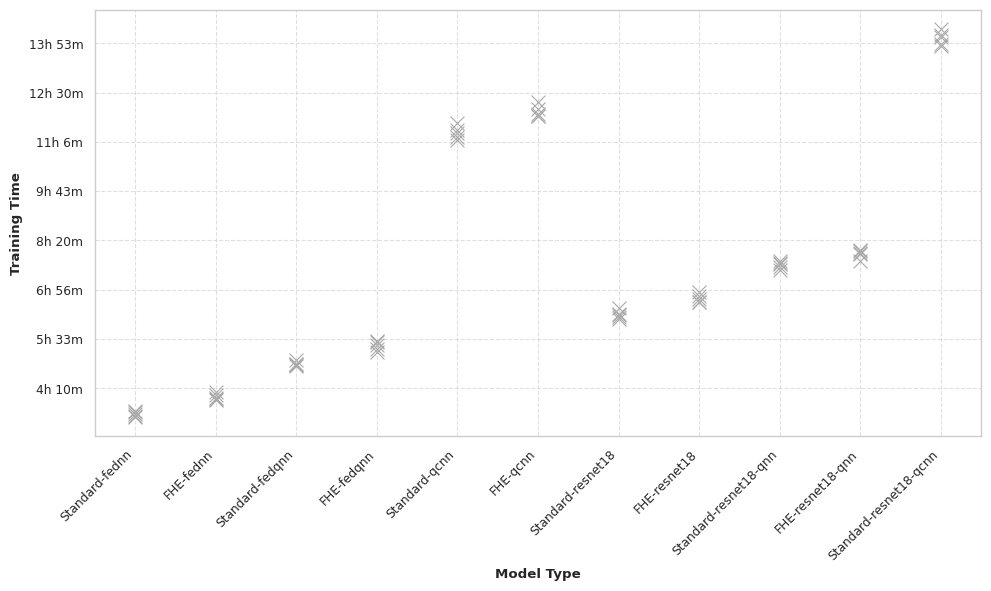

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"

def display_training_times_scatter_plot(training_times: dict):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))

    for model, times in training_times.items():
        sns.scatterplot(
            x=[model] * len(times),
            y=times,
            ax=ax,
            label=model,
            s=100,
            marker="x",
            color=COLOR,
        )

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model Type", fontweight="bold")
    plt.ylabel("Training Time", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)
    ax.yaxis.set_major_formatter(FuncFormatter(format_time))

    plt.tight_layout()

    if ax.get_legend() is not None:
        ax.get_legend().remove()

    plt.show()
    
display_training_times_scatter_plot(training_times)

In [50]:
metric_label = "Training Times (Minutes)"
df = get_dataframe_from_metrics_data(training_times, metric_label)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

Model Training Times (Minutes)                         \
                                              count        mean        std   
5           Standard-fednn                 0.083333  206.397414   4.198245   
0                FHE-fednn                 0.083333  235.924622   5.473660   
6          Standard-fedqnn                 0.083333  291.824683   3.992422   
1               FHE-fedqnn                 0.083333  321.866503   7.601587   
8        Standard-resnet18                 0.083333  374.639014   6.709202   
3             FHE-resnet18                 0.083333  402.297008   7.237238   
10   Standard-resnet18-qnn                 0.083333  458.479619   5.980606   
4         FHE-resnet18-qnn                 0.083333  477.396852   6.979638   
7            Standard-qcnn                 0.083333  682.231256  11.585660   
2                 FHE-qcnn                 0.083333  718.046793   9.871768   
9   Standard-resnet18-qcnn                 0.083333  842.036664  11.201412   

                                                                
           min         25%         50%         75%         max  
5   201.791917  202.861942  206.059314  210.033102  211.240794  
0   230.653374  232.020477  234.180645  238.723706  244.044909  
6   288.200825  290.014760  290.946286  291.330004  298.631538  
1   311.477119  317.176311  322.951576  327.839327  329.888180  
8   367.481466  370.470732  374.291951  375.827895  385.123029  
3   395.458787  396.277331  401.146677  405.621841  412.980402  
10  449.937233  455.142418  460.389549  461.788662  465.140230  
4   465.852546  476.526360  479.203318  481.894498  483.507539  
7   669.136421  674.460103  682.090369  686.239302  699.230087  
2   709.860702  711.043893  714.054688  721.560319  733.714363  
9   829.752540  832.533730  843.752443  846.766217  857.378388

### Round Times

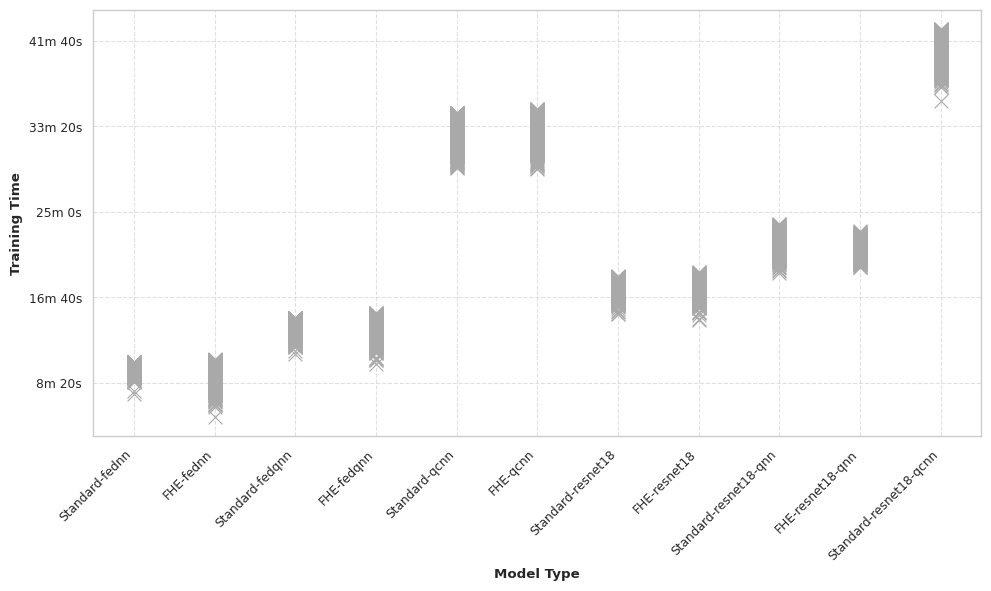

Model Client Round Times (Minutes)                       \
                                                  count       mean       std   
0                FHE-fednn                    33.333333   9.687771  0.625660   
5           Standard-fednn                    33.333333   9.818193  0.300696   
6          Standard-fedqnn                    33.333333  13.876930  0.465222   
1               FHE-fedqnn                    33.333333  13.891874  0.674002   
8        Standard-resnet18                    33.333333  17.762128  0.533725   
3             FHE-resnet18                    33.333333  17.904327  0.632366   
4         FHE-resnet18-qnn                    33.333333  21.712455  0.540821   
10   Standard-resnet18-qnn                    33.333333  21.868296  0.623483   
7            Standard-qcnn                    33.333333  32.948752  0.987532   
2                 FHE-qcnn                    33.333333  33.264183  0.955408   
9   Standard-resnet18-qcnn                    33.333333  40.713777  0.856305   

                                                           
          min        25%        50%        75%        max  
0    5.038325   9.486892   9.799829  10.040007  10.661978  
5    7.220746   9.644195   9.816323  10.057921  10.349568  
6   11.132450  13.632824  13.964829  14.171611  14.655724  
1   10.174227  13.566307  13.991692  14.368373  15.189501  
8   15.013081  17.463502  17.807555  18.154918  18.712647  
3   14.441303  17.554642  17.976781  18.329076  19.178867  
4   19.616562  21.356522  21.713544  22.162002  23.140476  
10  19.090340  21.451291  21.866156  22.315043  23.813871  
7   29.304053  32.340653  32.880883  33.679745  34.667629  
2   29.143281  32.689858  33.360062  33.914125  35.079574  
9   35.769302  40.140669  40.819056  41.343736  42.815809

In [ ]:
client_round_times = get_metric_by_model_type(runs, groups, "client_metric", "client_round_time")
client_round_times = {k: client_round_times[k] for k in KEY_ORDER}

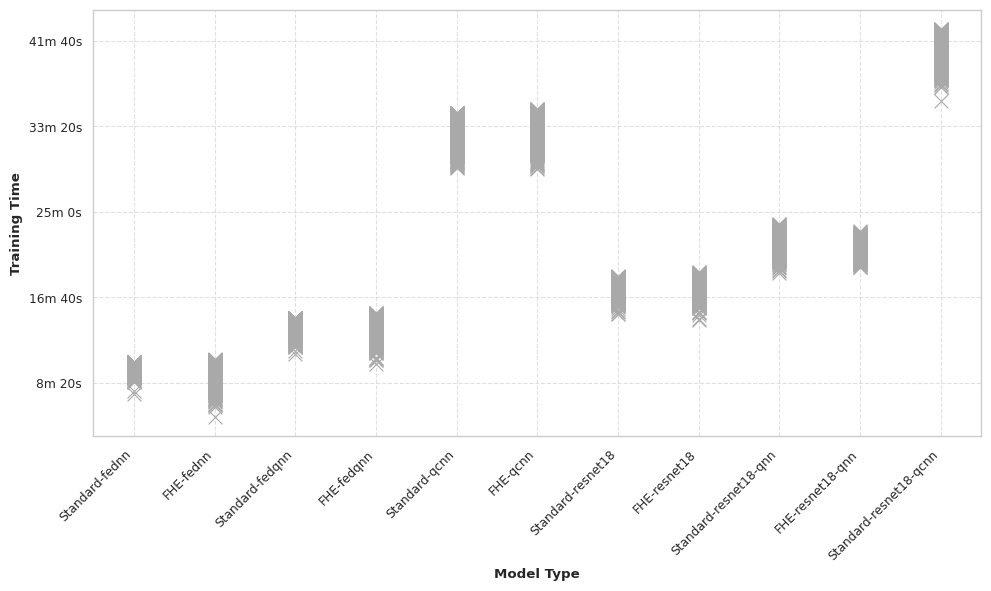

Model Client Round Times (Minutes)                       \
                                                  count       mean       std   
0                FHE-fednn                    33.333333   9.687771  0.625660   
5           Standard-fednn                    33.333333   9.818193  0.300696   
6          Standard-fedqnn                    33.333333  13.876930  0.465222   
1               FHE-fedqnn                    33.333333  13.891874  0.674002   
8        Standard-resnet18                    33.333333  17.762128  0.533725   
3             FHE-resnet18                    33.333333  17.904327  0.632366   
4         FHE-resnet18-qnn                    33.333333  21.712455  0.540821   
10   Standard-resnet18-qnn                    33.333333  21.868296  0.623483   
7            Standard-qcnn                    33.333333  32.948752  0.987532   
2                 FHE-qcnn                    33.333333  33.264183  0.955408   
9   Standard-resnet18-qcnn                    33.333333  40.713777  0.856305   

                                                           
          min        25%        50%        75%        max  
0    5.038325   9.486892   9.799829  10.040007  10.661978  
5    7.220746   9.644195   9.816323  10.057921  10.349568  
6   11.132450  13.632824  13.964829  14.171611  14.655724  
1   10.174227  13.566307  13.991692  14.368373  15.189501  
8   15.013081  17.463502  17.807555  18.154918  18.712647  
3   14.441303  17.554642  17.976781  18.329076  19.178867  
4   19.616562  21.356522  21.713544  22.162002  23.140476  
10  19.090340  21.451291  21.866156  22.315043  23.813871  
7   29.304053  32.340653  32.880883  33.679745  34.667629  
2   29.143281  32.689858  33.360062  33.914125  35.079574  
9   35.769302  40.140669  40.819056  41.343736  42.815809

In [59]:
metric_label = "Client Round Times (Minutes)"
display_training_times_scatter_plot(client_round_times)

df = get_dataframe_from_metrics_data(client_round_times, metric_label)
stats = (df.groupby("Model").describe() / 60).reset_index().sort_values((metric_label,  'mean'))
stats

# CPU Usage

In [24]:
client_cpu_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_cpu_percentage")

Checking group Standard-resnet18-qnn-14378202
Checking group Standard-resnet18-qnn-14288059
Checking group Standard-qcnn-14378198
Checking group Standard-fednn-14378194
Checking group FHE-resnet18-qnn-14166523
Checking group FHE-fedqnn-14378197
Checking group Standard-resnet18-14096298
Checking group FHE-fednn-14385574
Checking group FHE-qcnn-14385578
Checking group Standard-resnet18-14385579
Checking group FHE-fednn-14378195
Checking group Standard-fednn-14385573
Checking group Standard-resnet18-14166520
Checking group Standard-resnet18-14288057
Checking group Standard-fedqnn-14378196
Checking group FHE-resnet18-qnn-14288060
Checking group FHE-fedqnn-14288054
Checking group Standard-fedqnn-14385575
Checking group Standard-fednn-14166514
Checking group FHE-fedqnn-14166517
Checking group Standard-fedqnn-14288053
Checking group FHE-qcnn-14288056
Checking group Standard-fednn-14096292
Checking group Standard-resnet18-qcnn-14378204
Checking group FHE-qcnn-14096297
Checking group Standard-q

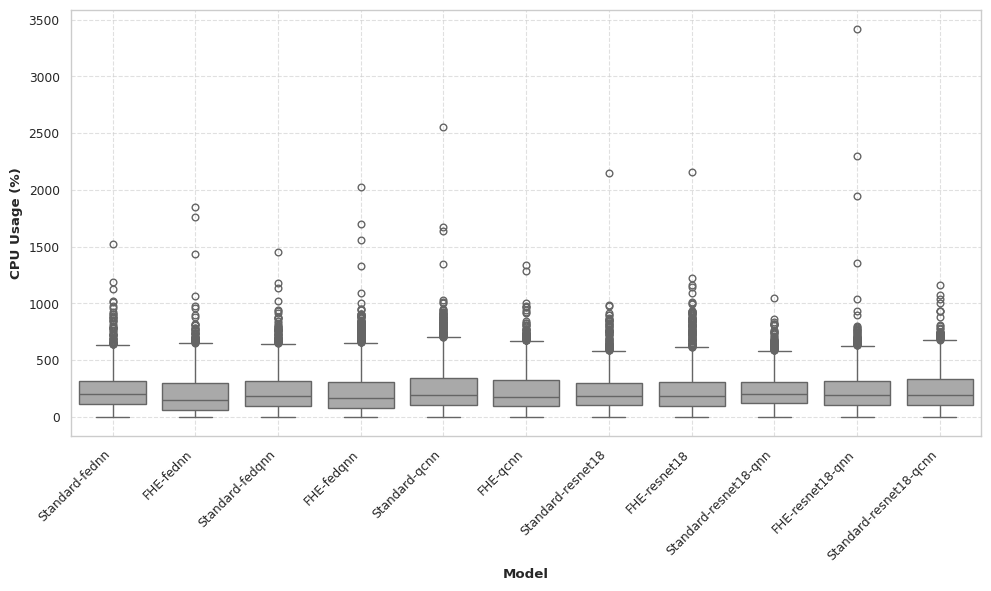

CPU Usage %                                       \
                             count        mean         std  min     25%   
Model                                                                     
FHE-fednn                   2437.0  194.166886  182.631701  0.0   57.90   
FHE-fedqnn                  2469.0  215.487282  201.718739  0.0   73.90   
FHE-qcnn                    2497.0  225.929275  181.599982  0.0   93.90   
FHE-resnet18                2486.0  221.758126  182.499945  0.0   97.90   
FHE-resnet18-qnn            2493.0  225.391817  179.896127  0.0  105.90   
Standard-fednn              2456.0  229.590228  160.497908  0.0  109.90   
Standard-fedqnn             2488.0  223.484887  169.443479  0.0   97.90   
Standard-qcnn               2483.0  242.549617  197.165568  0.0   99.90   
Standard-resnet18           2499.0  211.031813  163.198865  0.0   99.90   
Standard-resnet18-qcnn      2495.0  230.695832  169.531721  0.0   99.90   
Standard-resnet18-qnn       2495.0  226.480401  142.308734  0.0  118.35   

                                                
                          50%      75%     max  
Model                                           
FHE-fednn               147.8  295.700  1847.5  
FHE-fedqnn              161.8  305.700  2029.6  
FHE-qcnn                177.6  325.800  1334.6  
FHE-resnet18            183.8  305.675  2158.3  
FHE-resnet18-qnn        193.8  313.700  3416.5  
Standard-fednn          203.8  319.250  1520.5  
Standard-fedqnn         185.8  317.700  1450.6  
Standard-qcnn           193.8  339.700  2553.6  
Standard-resnet18       185.8  293.700  2147.6  
Standard-resnet18-qcnn  191.8  329.700  1162.9  
Standard-resnet18-qnn   203.5  304.100  1046.9

In [ ]:
metric_label = "CPU Usage %"
df = get_dataframe_from_metrics_data(client_cpu_usage, metric_label)

def display_boxplot(metrics_df: pd.DataFrame, metric_label: str) -> pd.DataFrame:

    sns.set_theme(style="whitegrid", context="paper")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Model", y=metric_label, data=metrics_df, color=COLOR)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model", fontweight="bold")
    plt.ylabel("CPU Usage (%)", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Display the plot
    plt.tight_layout()
    plt.show()

display_boxplot(df, metric_label)
df.groupby("Model").describe()

# RAM Usage

In [30]:
client_vir_ram_usage = get_metric_by_model_type(runs, groups, "system_metric", "client_virtual_memory_mb")
client_vir_ram_usage = {k: client_vir_ram_usage[k] for k in KEY_ORDER}

Checking group Standard-resnet18-qnn-14378202
Checking group Standard-resnet18-qnn-14288059
Checking group Standard-qcnn-14378198
Checking group Standard-fednn-14378194
Checking group FHE-resnet18-qnn-14166523
Checking group FHE-fedqnn-14378197
Checking group Standard-resnet18-14096298
Checking group FHE-fednn-14385574
Checking group FHE-qcnn-14385578
Checking group Standard-resnet18-14385579
Checking group FHE-fednn-14378195
Checking group Standard-fednn-14385573
Checking group Standard-resnet18-14166520
Checking group Standard-resnet18-14288057
Checking group Standard-fedqnn-14378196
Checking group FHE-resnet18-qnn-14288060
Checking group FHE-fedqnn-14288054
Checking group Standard-fedqnn-14385575
Checking group Standard-fednn-14166514
Checking group FHE-fedqnn-14166517
Checking group Standard-fedqnn-14288053
Checking group FHE-qcnn-14288056
Checking group Standard-fednn-14096292
Checking group Standard-resnet18-qcnn-14378204
Checking group FHE-qcnn-14096297
Checking group Standard-q

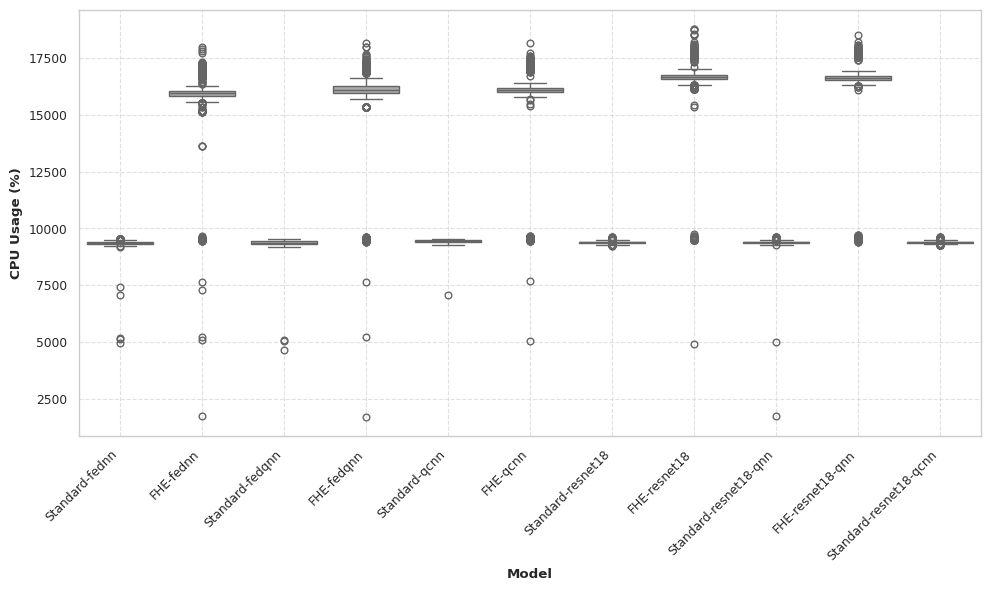

Virtual RAM Usage (MB)                             \
                                        count          mean          std   
Model                                                                      
FHE-fednn                              2435.0  15820.222611  1298.495865   
FHE-fedqnn                             2470.0  15907.350000  1472.514505   
FHE-qcnn                               2499.0  15843.575650  1473.295450   
FHE-resnet18                           2491.0  16427.822829  1544.552883   
FHE-resnet18-qnn                       2493.0  16369.904662  1534.033076   
Standard-fednn                         2452.0   9349.798206   170.419578   
Standard-fedqnn                        2485.0   9371.268765   167.125312   
Standard-qcnn                          2488.0   9430.353571    76.792078   
Standard-resnet18                      2495.0   9392.590890    54.758848   
Standard-resnet18-qcnn                 2495.0   9393.109823    43.666784   
Standard-resnet18-qnn                  2493.0   9389.111065   184.310209   

                                                                       \
                             min         25%         50%          75%   
Model                                                                   
FHE-fednn               1762.258  15842.9530  15943.0510  16033.54700   
FHE-fedqnn              1707.203  15978.2860  16107.3300  16247.37500   
FHE-qcnn                5037.602  16007.9690  16098.6760  16192.45300   
FHE-resnet18            4913.305  16586.7420  16655.3400  16773.07800   
FHE-resnet18-qnn        9397.137  16544.1990  16601.9180  16707.58200   
Standard-fednn          4941.805   9318.3200   9346.7445   9380.40200   
Standard-fedqnn         4642.070   9326.5550   9364.6560   9432.00000   
Standard-qcnn           7088.895   9381.1840   9449.6880   9481.19575   
Standard-resnet18       9207.832   9357.1230   9387.1290   9417.82400   
Standard-resnet18-qcnn  9264.668   9366.5725   9392.8670   9413.72100   
Standard-resnet18-qnn   1720.730   9358.6370   9388.4410   9416.66400   

                                   
                              max  
Model                              
FHE-fednn               17984.836  
FHE-fedqnn              18167.141  
FHE-qcnn                18174.703  
FHE-resnet18            18767.879  
FHE-resnet18-qnn        18500.137  
Standard-fednn           9554.402  
Standard-fedqnn          9551.223  
Standard-qcnn            9546.438  
Standard-resnet18        9635.684  
Standard-resnet18-qcnn   9636.809  
Standard-resnet18-qnn    9630.391

In [35]:
metric_label = "Virtual RAM Usage (MB)"
df = get_dataframe_from_metrics_data(client_vir_ram_usage, metric_label)

display_boxplot(df, metric_label)
df.groupby("Model").describe()